# Supervised Classification Using Random Forests (DRF)
___

Author: Diego Lopez

Date: 08/13/2022

Notes: This file contains code to train, validate and score a distributed random forest on the processed KDD Cup 1999 training and test data. This is a supervised approach on the 10% training data sample. 

## Data Importing & Formatting
___

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import h2o
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators import H2OGradientBoostingEstimator
from h2o.estimators import H2ORandomForestEstimator
from sklearn.metrics import classification_report

In [2]:
# initialize h2o server
h2o.init(max_mem_size=9)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_341"; Java(TM) SE Runtime Environment (build 1.8.0_341-b10); Java HotSpot(TM) 64-Bit Server VM (build 25.341-b10, mixed mode)
  Starting server from /Users/diego/miniforge3/envs/tf/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/gx/j98lvm7j4pvds6m3w0frhncw0000gn/T/tmpm2kwbekr
  JVM stdout: /var/folders/gx/j98lvm7j4pvds6m3w0frhncw0000gn/T/tmpm2kwbekr/h2o_diego_started_from_python.out
  JVM stderr: /var/folders/gx/j98lvm7j4pvds6m3w0frhncw0000gn/T/tmpm2kwbekr/h2o_diego_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.1
H2O_cluster_version_age:,4 months !!!
H2O_cluster_name:,H2O_from_python_diego_h02blp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [3]:
# upload data to server
train = h2o.import_file("../data/processed/traindata.csv")
test = h2o.import_file("../data/processed/testdata.csv")

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [4]:
# TODO: can this be done when importing?
test = test[1:, 1:]
train = train[1:, 1:]

In [5]:
train.head(5)

duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_hostnames,service_http,service_http_443,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,service_icmp
0,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0,0,0,0,1,0,0,29,29,1,0,0.03,0,0,0,0,0,normal,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
0,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0,0,0,0,1,0,0,39,39,1,0,0.03,0,0,0,0,0,normal,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
0,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0,0,0,0,1,0,0,49,49,1,0,0.02,0,0,0,0,0,normal,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
0,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0,0,0,0,1,0,0,59,59,1,0,0.02,0,0,0,0,0,normal,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
0,212,1940,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,0,1,0,1,1,69,1,0,1,0.04,0,0,0,0,normal,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [6]:
test.head(5)

duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_hostnames,service_http,service_http_443,service_icmp,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pop_2,service_pop_3,service_printer,service_private,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,service_pm_dump,service_red_i,service_urh_i
0,105,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,255,254,1,0.01,0,0,0,0,0,0,normal,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
0,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0.5,1,0,10,3,0.3,0.3,0.3,0,0,0,0,0,normal,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
0,105,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,255,253,0.99,0.01,0,0,0,0,0,0,normal,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
0,223,185,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4,4,0,0,0,0,1,0,0,71,255,1,0,0.01,0.01,0,0,0,0,normal,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
0,230,260,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,19,0,0,0,0,1,0,0.11,3,255,1,0,0.33,0.07,0.33,0,0,0,normal,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [8]:
len(test.columns) == len(train.columns)

True

## Model Training
___

We use random search to explore the hyperparameter space.

5 models are used due to computational limitations. If more resources were available, we would evaluate more models.

In [9]:
# Using Random Search with 5 models max (due to computational limitations)
search_criteria = {'strategy': 'RandomDiscrete', 'max_models': 5, 'seed': 2, }
x = test.columns
x.remove("labels")
y = "labels"

In [10]:
# random forest hyperparameters
clf_rf_params = {
    "ntrees" : [i for i in range(100, 375, 50)], # more trees would be tested however we see performance increase plateau at ~300 tress
    "max_depth" : [i for i in range(5, 30, 5)], 
    "nbins" : [pow(2, i) for i in range(4, 8)], # exponentially increase nbins size between 16 and 256
    "nbins_top_level" : [pow(2,i) for i in range(9, 12)], # exponentially increase nbins top level between 512 and 2048
    "stopping_metric" : ["logloss"],
    'sample_rate' : [0.32, 0.63],
    "stopping_tolerance" : [0.001], 
    "stopping_rounds" : [2],    
    "seed" : [1], 
    "histogram_type" : ['AUTO', "RoundRobin", "QuantilesGlobal"],
    "min_rows" : [i for i in range(1,11)],
    "mtries" : [-1], # use square root of number of columns as features to weak learners
}

# total fits = nfolds * num_models
rf_grid1 = H2OGridSearch(H2ORandomForestEstimator(nfolds=5, auc_type="MACRO_OVR", keep_cross_validation_models=False, score_tree_interval=5), grid_id="rf_grid1", hyper_params=clf_rf_params, search_criteria=search_criteria)
rf_grid1.train(x=x, y=y, training_frame=train) # Standard operating procedure is 5 fold 

drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
      histogram_type  max_depth  min_rows  mtries  nbins  nbins_top_level  \
0    UniformAdaptive        5.0       8.0    -1.0   64.0           1024.0   
1         RoundRobin       15.0      10.0    -1.0   64.0           1024.0   
2         RoundRobin       15.0       1.0    -1.0   32.0            512.0   
3         RoundRobin       25.0       3.0    -1.0   32.0           1024.0   
4         RoundRobin       25.0       5.0    -1.0   64.0            512.0   

   ntrees  sample_rate  seed stopping_metric  stopping_rounds  \
0    21.0         0.63   5.0         logloss              0.0   
1    25.0         0.63   6.0         logloss              0.0   
2    28.0         0.32   2.0         logloss              0.0   
3    17.0         0.63   4.0         logloss              0.0   
4    23.0         0.63   3.0         logloss              0.0   

   stopping_tolerance         model_ids   logloss  

In [11]:
rf_gridperf1 = rf_grid1.get_grid(sort_by="pr_auc", decreasing=True)

In [12]:
rf_gridperf1

      histogram_type  max_depth  min_rows  mtries  nbins  nbins_top_level  \
0         RoundRobin       15.0       1.0    -1.0   32.0            512.0   
1         RoundRobin       25.0       3.0    -1.0   32.0           1024.0   
2    UniformAdaptive        5.0       8.0    -1.0   64.0           1024.0   
3         RoundRobin       25.0       5.0    -1.0   64.0            512.0   
4         RoundRobin       15.0      10.0    -1.0   64.0           1024.0   

   ntrees  sample_rate  seed stopping_metric  stopping_rounds  \
0    28.0         0.32   2.0         logloss              0.0   
1    17.0         0.63   4.0         logloss              0.0   
2    21.0         0.63   5.0         logloss              0.0   
3    23.0         0.63   3.0         logloss              0.0   
4    25.0         0.63   6.0         logloss              0.0   

   stopping_tolerance         model_ids    pr_auc  
0               0.001  rf_grid1_model_1  0.802621  
1               0.001  rf_grid1_model_3  0

In [13]:
best_rf1 = rf_gridperf1.models[0]

In [14]:
best_rf1

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  rf_grid1_model_1


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,28.0,588.0,178212.0,1.0,15.0,7.011905,1.0,165.0,19.263605




ModelMetricsMultinomial: drf
** Reported on train data. **

MSE: 0.0025063329682002418
RMSE: 0.050063289626234526
LogLoss: 0.03192442774453263
Mean Per-Class Error: 0.3676841185395091
AUC: 0.9963662662705458
AUCPR: 0.8176786074246077

Multinomial AUC values: 


,type,first_class_domain,second_class_domain,auc
0,back vs Rest,back,None,1.000000
1,buffer_overflow vs Rest,buffer_overflow,None,0.999978
2,ftp_write vs Rest,ftp_write,None,0.999433
3,guess_passwd vs Rest,guess_passwd,None,0.989293
4,imap vs Rest,imap,None,0.999999
5,ipsweep vs Rest,ipsweep,None,0.999986
6,land vs Rest,land,None,0.999998
7,loadmodule vs Rest,loadmodule,None,0.971272
8,multihop vs Rest,multihop,None,0.999957
9,neptune vs Rest,neptune,None,1.000000



See the whole table with table.as_data_frame()

Multinomial auc_pr values: 


,type,first_class_domain,second_class_domain,auc_pr
0,back vs Rest,back,None,0.999998
1,buffer_overflow vs Rest,buffer_overflow,None,0.814497
2,ftp_write vs Rest,ftp_write,None,0.191665
3,guess_passwd vs Rest,guess_passwd,None,0.980776
4,imap vs Rest,imap,None,0.965804
5,ipsweep vs Rest,ipsweep,None,0.995149
6,land vs Rest,land,None,0.885815
7,loadmodule vs Rest,loadmodule,None,0.099389
8,multihop vs Rest,multihop,None,0.406418
9,neptune vs Rest,neptune,None,1.000000



See the whole table with table.as_data_frame()

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,back,buffer_overflow,ftp_write,guess_passwd,imap,ipsweep,land,loadmodule,multihop,neptune,...,phf,pod,portsweep,rootkit,satan,smurf,teardrop,warezmaster,Error,Rate
0,2197.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002724,"6 / 2,203"
1,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.433333,13 / 30
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,8 / 8
3,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.056604,3 / 53
4,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,4 / 12
5,0.0,0.0,0.0,0.0,0.0,1229.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014435,"18 / 1,247"
6,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,3 / 21
7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,9 / 9
8,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,7 / 7
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,107199.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000019,"2 / 107,201"



See the whole table with table.as_data_frame()

Top-10 Hit Ratios: 


,k,hit_ratio
0,1,0.999389
1,2,0.999826
2,3,0.999923
3,4,0.999947
4,5,0.999959
5,6,0.999970
6,7,0.999976
7,8,0.999982
8,9,0.999986
9,10,0.999988



ModelMetricsMultinomial: drf
** Reported on cross-validation data. **

MSE: 0.0028773149658885854
RMSE: 0.053640609298260075
LogLoss: 0.03878048133933185
Mean Per-Class Error: 0.3945158272910308
AUC: 0.9864487637851473
AUCPR: 0.8026211085913696

Multinomial AUC values: 


,type,first_class_domain,second_class_domain,auc
0,back vs Rest,back,None,1.000000
1,buffer_overflow vs Rest,buffer_overflow,None,0.999967
2,ftp_write vs Rest,ftp_write,None,0.963393
3,guess_passwd vs Rest,guess_passwd,None,0.999997
4,imap vs Rest,imap,None,0.995511
5,ipsweep vs Rest,ipsweep,None,0.999874
6,land vs Rest,land,None,0.999999
7,loadmodule vs Rest,loadmodule,None,0.849962
8,multihop vs Rest,multihop,None,0.999947
9,neptune vs Rest,neptune,None,1.000000



See the whole table with table.as_data_frame()

Multinomial auc_pr values: 


,type,first_class_domain,second_class_domain,auc_pr
0,back vs Rest,back,None,0.999999
1,buffer_overflow vs Rest,buffer_overflow,None,0.780512
2,ftp_write vs Rest,ftp_write,None,0.264203
3,guess_passwd vs Rest,guess_passwd,None,0.987455
4,imap vs Rest,imap,None,0.916703
5,ipsweep vs Rest,ipsweep,None,0.995730
6,land vs Rest,land,None,0.951829
7,loadmodule vs Rest,loadmodule,None,0.126220
8,multihop vs Rest,multihop,None,0.361944
9,neptune vs Rest,neptune,None,0.999999



See the whole table with table.as_data_frame()

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,back,buffer_overflow,ftp_write,guess_passwd,imap,ipsweep,land,loadmodule,multihop,neptune,...,phf,pod,portsweep,rootkit,satan,smurf,teardrop,warezmaster,Error,Rate
0,2194.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004085,"9 / 2,203"
1,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.533333,16 / 30
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,8 / 8
3,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.056604,3 / 53
4,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.416667,5 / 12
5,0.0,0.0,0.0,0.0,0.0,1230.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013633,"17 / 1,247"
6,0.0,0.0,0.0,0.0,0.0,0.0,19.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.095238,2 / 21
7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,9 / 9
8,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,7 / 7
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,107198.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000028,"3 / 107,201"



See the whole table with table.as_data_frame()

Top-10 Hit Ratios: 


,k,hit_ratio
0,1,0.999385
1,2,0.999854
2,3,0.999919
3,4,0.999935
4,5,0.999951
5,6,0.999961
6,7,0.999963
7,8,0.999970
8,9,0.999974
9,10,0.999976



Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.999394,0.000063,0.999341,0.999422,0.999443,0.999451,0.999311
1,auc,0.922451,0.025777,0.902001,0.952215,0.904642,0.949065,0.904335
2,err,0.000606,0.000063,0.000659,0.000578,0.000557,0.000549,0.000689
3,err_count,59.800000,6.300794,65.000000,57.000000,55.000000,54.000000,68.000000
4,logloss,0.049522,0.020594,0.025866,0.059801,0.033360,0.051372,0.077209
5,max_per_class_error,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
6,mean_per_class_accuracy,0.693247,0.013239,0.709518,0.694329,0.698987,0.689934,0.673466
7,mean_per_class_error,0.306753,0.013239,0.290482,0.305671,0.301013,0.310066,0.326534
8,mse,0.003805,0.001797,0.002019,0.004649,0.002213,0.003794,0.006350
9,pr_auc,0.793503,0.049234,0.816930,0.860326,0.744885,0.799623,0.745749



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error,training_auc,training_pr_auc
0,,2022-08-13 23:34:12,8 min 53.913 sec,0.0,NaN,NaN,NaN,NaN,NaN
1,,2022-08-13 23:34:23,9 min 4.932 sec,5.0,0.097566,0.249849,0.007536,0.983024,0.643004
2,,2022-08-13 23:34:34,9 min 16.214 sec,10.0,0.053866,0.041072,0.000730,0.991230,0.745618
3,,2022-08-13 23:34:49,9 min 30.508 sec,15.0,0.047737,0.030514,0.000600,0.991983,0.765939
4,,2022-08-13 23:35:03,9 min 44.419 sec,20.0,0.054492,0.036256,0.000631,0.994620,0.825785
5,,2022-08-13 23:35:16,9 min 57.815 sec,25.0,0.050648,0.032887,0.000619,0.994666,0.833069
6,,2022-08-13 23:35:26,10 min 7.799 sec,28.0,0.050063,0.031924,0.000611,0.996366,0.817679



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,count,574307.687500,1.000000,0.102903
1,dst_host_same_src_port_rate,534031.875000,0.929871,0.095686
2,protocol_type_icmp,522402.312500,0.909621,0.093603
3,srv_count,460040.437500,0.801035,0.082429
4,dst_host_same_srv_rate,366072.187500,0.637415,0.065592
5,same_srv_rate,336047.718750,0.585135,0.060212
6,logged_in,331515.218750,0.577243,0.059400
7,service_ecr_i,298382.312500,0.519551,0.053463
8,service_private,261848.578125,0.455938,0.046917
9,dst_host_diff_srv_rate,249066.156250,0.433681,0.044627



See the whole table with table.as_data_frame()


In [15]:
# test data
best_rf1_perf = best_rf1.model_performance(test)

In [16]:
best_rf1_perf.confusion_matrix().as_data_frame()

,back,buffer_overflow,ftp_write,guess_passwd,imap,ipsweep,land,loadmodule,multihop,neptune,...,phf,pod,portsweep,rootkit,satan,smurf,teardrop,warezmaster,Error,Rate
0,1075.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020947,"23 / 1,098"
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,22 / 22
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,3 / 3
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,"4,367 / 4,367"
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1 / 1
5,0.0,0.0,0.0,0.0,0.0,297.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.029412,9 / 306
6,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.444444,4 / 9
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,2 / 2
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,18 / 18
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57986.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000259,"15 / 58,001"


In [20]:
predictions_test = best_rf1.predict(test[:,x])

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [23]:
predictions_test.as_data_frame()['predict'].value_counts()

smurf              164094
normal              66429
neptune             57992
satan                1768
back                 1075
portsweep             411
ipsweep               297
pod                    95
nmap                   84
teardrop               47
land                    5
buffer_overflow         1
Name: predict, dtype: int64

In [41]:
cr = classification_report(test[:,'labels'].as_data_frame(), predictions_test.as_data_frame()['predict'], output_dict=True, zero_division=0)

Text(0.5, 1.0, 'Classification Report for Random Forest Model')

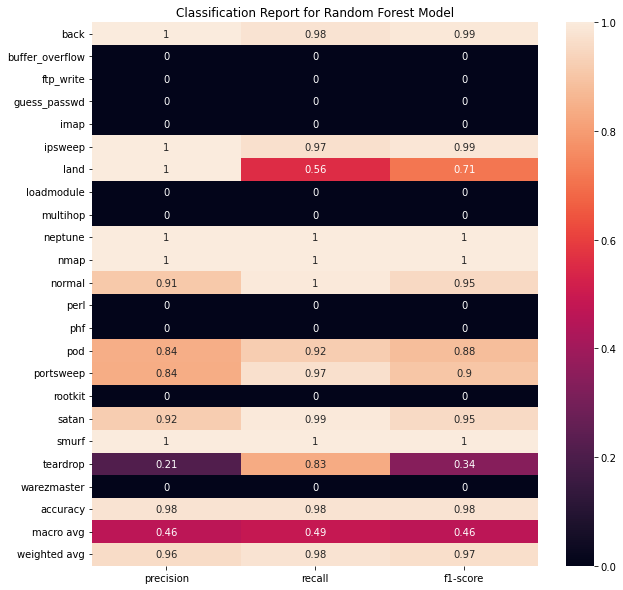

In [42]:
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True, ax=ax)
plt.title("Classification Report for Random Forest Model")

In [44]:
# path is relative
model_path = h2o.save_model(model=best_rf1, path="../models/", force=True)
model_path

'/Users/diego/Projects/kdd99_analysis_IDS/models/rf_grid1_model_1'